# DEBERTA Fine-Tuning on CoLA with SMART and SiFT

This notebook is orginally created by Chris McCormick and Nick Ryan. We made changes for SiFT and SMART, as well as our custom BERT class.

##Data and Importing Modules 

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
!pip install transformers

     |████████████████████████████████| 2.3MB 30.7MB/s 
     |████████████████████████████████| 3.3MB 37.1MB/s 
     |████████████████████████████████| 901kB 46.3MB/s 


In [4]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=c69248b0eda8043f473b456aa39b4c0c9850808bf22638703c3652b2a45d5859
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [5]:
#Adding the datasets to the collab file

#First we mount the google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# with open('/content/drive/My Drive/Undergraduate/Courses/MLLU Project/Code/Baseline - Draft Proposal/yelp_labelled.txt', 'r') as f:
#   f.write('Successfully opened Yelp Labelled')

with open('/content/drive/MyDrive/Undergraduate /Courses /MLLU Project/Code/MLLU : Final Paper Submission Code/yelp_labelled.txt', 'r') as y:
  print("Successfully Opened Yelp")


with open('/content/drive/MyDrive/Undergraduate /Courses /MLLU Project/Code/MLLU : Final Paper Submission Code/amazon_cells_labelled.txt', 'r') as a:
  print("Successfully Opened Amazon Labelled")



with open('/content/drive/MyDrive/Undergraduate /Courses /MLLU Project/Code/MLLU : Final Paper Submission Code/imdb_labelled.txt', 'r') as i:
  print("Successfully Opened IMDB Labelled")

Successfully Opened Yelp
Successfully Opened Amazon Labelled
Successfully Opened IMDB Labelled


In [7]:
#Checking on the Yelp Dataframe
import pandas as pd
df1_yelp = pd.read_csv('/content/drive/MyDrive/Undergraduate /Courses /MLLU Project/Code/MLLU : Final Paper Submission Code/yelp_labelled.txt', delimiter = '\t', delim_whitespace= False, names = ('Sentence', 'Label'))
df1_yelp.head()

print(df1_yelp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  1000 non-null   object
 1   Label     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
None


In [8]:

#Similarly for the dataframes for Amazon and IMDB
df1_amazon = pd.read_csv('/content/drive/MyDrive/Undergraduate /Courses /MLLU Project/Code/MLLU : Final Paper Submission Code/amazon_cells_labelled.txt', delimiter = '\t', delim_whitespace= False, names = ('Sentence', 'Label'))
df1_amazon.head()
print(df1_amazon.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  1000 non-null   object
 1   Label     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
None


In [9]:
df1_imdb = pd.read_csv('/content/drive/MyDrive/Undergraduate /Courses /MLLU Project/Code/MLLU : Final Paper Submission Code/imdb_labelled.txt', delimiter = '\t', delim_whitespace= False, names = ('Sentence', 'Label'))
df1_imdb.head()
print(df1_imdb.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  748 non-null    object
 1   Label     748 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.8+ KB
None


In [10]:

combinedDF = pd.concat([df1_imdb, df1_amazon, df1_yelp], axis = 0, join = 'inner')
combinedDF.head()
combinedDF.info()
combinedDF.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2748 non-null   object
 1   Label     2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 64.4+ KB


,Sentence,Label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
5,"The rest of the movie lacks art, charm, meanin...",0
6,Wasted two hours.,0
7,Saw the movie today and thought it was a good ...,1
8,A bit predictable.,0
9,Loved the casting of Jimmy Buffet as the scien...,1


In [ ]:
combinedDF = combinedDF.sample(frac = 1).reset_index(drop = True)
combinedDF = combinedDF.dropna()
combinedDF.info()
combinedDF.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2748 non-null   object
 1   Label     2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 64.4+ KB


,Sentence,Label
0,They really want to make your experience a goo...,1
1,Whatever prompted such a documentary is beyond...,0
2,The case is a flimsy piece of plastic and has ...,0
3,The real disappointment was our waiter.,0
4,Hated it.,0
5,The manager was the worst.,0
6,Artless camera-work endlessly presents us with...,0
7,Very disappointed and wondered how it could be...,0
8,I love that they put their food in nice plasti...,1
9,Food was below average.,0


In [11]:
df1_twitter = pd.read_csv('/content/drive/MyDrive/Undergraduate /Courses /MLLU Project/Code/MLLU : Final Paper Submission Code/train.csv', names = ('Label', 'Sentence'))
df1_twitter = df1_twitter.iloc[1:4000]

df1_twitter['Label'] = df1_twitter['Label'].astype(int, errors = 'raise')

In [12]:
df1_twitter.head()
df1_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3999 entries, 1 to 3999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Label     3999 non-null   int64 
 1   Sentence  3999 non-null   object
dtypes: int64(1), object(1)
memory usage: 93.7+ KB


In [13]:
df1_twitter.head(10)
sentences = df1_twitter.Sentence.values
labels = df1_twitter.Label.values

print(type(labels[0]))

<class 'numpy.int64'>


## Tokenization and DataLoader

In [14]:
from transformers import DebertaTokenizer
print('Loading DeBERTa tokenizer...')
tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base', do_lower_case=True)

Loading DeBERTa tokenizer...


In [15]:
print(' Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:   @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
Tokenized:  ['Ġ@', 'user', 'Ġwhen', 'Ġa', 'Ġfather', 'Ġis', 'Ġdysfunctional', 'Ġand', 'Ġis', 'Ġso', 'Ġselfish', 'Ġhe', 'Ġdr', 'ags', 'Ġhis', 'Ġkids', 'Ġinto', 'Ġhis', 'Ġdysfunction', '.', 'Ġ', 'Ġ', 'Ġ#', 'run']
Token IDs:  [787, 12105, 77, 10, 1150, 16, 30599, 8, 16, 98, 20462, 37, 12402, 8299, 39, 1159, 88, 39, 26971, 4, 1437, 1437, 849, 2962]


In [16]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))


print(len(sentences))
print('Max sentence length: ', max_len)

3999
Max sentence length:  192


In [17]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 32,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:   @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
Token IDs: tensor([    1,   787, 12105,    77,    10,  1150,    16, 30599,     8,    16,
           98, 20462,    37, 12402,  8299,    39,  1159,    88,    39, 26971,
            4,  1437,  1437,   849,  2962,     2,     0,     0,     0,     0,
            0,     0])


In [18]:

from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
print(type(input_ids))
print(type(attention_masks))
print(type(labels))
# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
3,599 training samples
  400 validation samples


In [19]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. 
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


print("hi")

hi


*italicized text*## Custom DEBerta Class and Initialization

In [20]:
from transformers import DebertaForSequenceClassification, AdamW, DebertaConfig, DebertaPreTrainedModel, DebertaModel
from transformers.models.deberta.modeling_deberta import *
#from transformers.modeling_outputs import BaseModelOutputWithPoolingAndCrossAttentions

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss

class CustomDebertaForClassification(DebertaForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        #self.bert = BertForSequenceClassification(config).from_pretrained("bert-base-uncased",num_labels = 2,output_attentions = False, output_hidden_states = False)
        self.embeddings = self.deberta.embeddings
        self.encoder = self.deberta.encoder
        self.z_steps = 0 #copied from DebertaModel source code


    def embed(self, input_ids=None, 
                    mask=None,
                    token_type_ids=None, 
                    position_ids=None, 
                    inputs_embeds=None
                    ):
        # See: BERTModel.forward
        return self.embeddings(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            mask=mask,
            inputs_embeds=inputs_embeds
        )
    
    def predict(self,embedding_output,
                attention_mask=None,
                head_mask=None,
                encoder_hidden_states=None,
                encoder_extended_attention_mask=None,
                past_key_values=None,
                use_cache=None,
                output_attentions=None,
                output_hidden_states=None,
                return_dict=True): 
        encoder_outputs = self.encoder(
                                        embedding_output,
                                        attention_mask,
                                        output_hidden_states=True,
                                        output_attentions=output_attentions,
                                        return_dict=return_dict
        )
        encoded_layers = encoder_outputs[1]

        if self.z_steps > 1:
            hidden_states = encoded_layers[-2]
            layers = [self.encoder.layer[-1] for _ in range(self.z_steps)]
            query_states = encoded_layers[-1]
            rel_embeddings = self.encoder.get_rel_embedding()
            attention_mask = self.encoder.get_attention_mask(attention_mask)
            rel_pos = self.encoder.get_rel_pos(embedding_output)
            for layer in layers[1:]:
                query_states = layer(
                    hidden_states,
                    attention_mask,
                    return_att=False,
                    query_states=query_states,
                    relative_pos=rel_pos,
                    rel_embeddings=rel_embeddings,
                )
                encoded_layers.append(query_states)

        sequence_output = encoded_layers[-1]

        # if not return_dict:
        #     return (sequence_output,) + encoder_outputs[(1 if output_hidden_states else 2) :]

        outputs = BaseModelOutput(
            last_hidden_state=sequence_output,
            hidden_states=encoder_outputs.hidden_states if output_hidden_states else None,
            attentions=encoder_outputs.attentions,
        )

        

        pooled_output = self.pooler(outputs[0])
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        return logits

In [21]:

#@title
model = CustomDebertaForClassification.from_pretrained(
    "microsoft/deberta-base",
    num_labels = 2,
    output_attentions = False, 
    output_hidden_states = False, 
)

model.cuda()

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing CustomDebertaForClassification: ['lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'config']
- This IS expected if you are initializing CustomDebertaForClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CustomDebertaForClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CustomDebertaForClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['encoder.layer.2.intermediat

CustomDebertaForClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0): DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
          (intermedia

##Noise Function

In [22]:
from torch.nn import LayerNorm
import torch.nn.functional as F

def stable_kl(logit, target, epsilon=1e-6, reduce=True):
    logit = logit.view(-1, logit.size(-1)).float()
    target = target.view(-1, target.size(-1)).float()
    bs = logit.size(0)
    p = F.log_softmax(logit, 1).exp()
    y = F.log_softmax(target, 1).exp()
    rp = -(1.0/(p + epsilon) -1 + epsilon).detach().log()
    ry = -(1.0/(y + epsilon) -1 + epsilon).detach().log()
    if reduce:
        return (p* (rp- ry) * 2).sum() / bs
    else:
        return (p* (rp- ry) * 2).sum()

def _norm_grad(grad, epsilon = 1e-6, eff_grad=None, sentence_level=False):
        if sentence_level:
            direction = grad / (grad.abs().max((-2, -1), keepdim=True)[0] + epsilon)
        else:
            direction = grad / (grad.abs().max(-1, keepdim=True)[0] + epsilon)
            eff_direction = eff_grad / (grad.abs().max(-1, keepdim=True)[0] + epsilon)
        return direction, eff_direction

def noise(embed, model, step_size, normalize=False, k=1, mean=0, std=0.01):
    if normalize == True:
        logits = model.predict(embed)
        LNorm = LayerNorm(embed.size(),elementwise_affine=False)
        normalized_embed = LNorm(embed)
        
        noise = torch.normal(mean=0, std=0.01,size=(normalized_embed.size()[0],normalized_embed.size()[1],normalized_embed.size()[2]))
        noise = noise.to(device)
        noise.requires_grad_()
        noised_normalized_embeddings = normalized_embed+noise
        adv_logits = model.predict(noised_normalized_embeddings)
        adv_loss = stable_kl(adv_logits, logits.detach(), reduce=False)
        delta_grad, = torch.autograd.grad(adv_loss, noise, only_inputs=True, retain_graph=False)
        norm = delta_grad.norm()
        # if (torch.isnan(norm) or torch.isinf(norm)):
        #     return 0
        eff_delta_grad = delta_grad * step_size
        delta_grad = noise + delta_grad * step_size
        noise, eff_noise = _norm_grad(delta_grad, eff_grad=eff_delta_grad, sentence_level=0)
        noise = noise.detach()
        noised_normalized_embeddings = normalized_embed+noise
        return noised_normalized_embeddings

    else:
        logits = model.predict(embed)
        noise = torch.normal(mean=0, std=0.01,size=(embed.size()[0],embed.size()[1],embed.size()[2]))
        noise = noise.to(device)
        noise.requires_grad_()
        noised_embeddings = embed+noise
        adv_logits = model.predict(noised_embeddings)
        adv_loss = stable_kl(adv_logits, logits.detach(), reduce=False)
        delta_grad, = torch.autograd.grad(adv_loss, noise, only_inputs=True, retain_graph=False)
        norm = delta_grad.norm()
        # if (torch.isnan(norm) or torch.isinf(norm)):
        #     return 0
        eff_delta_grad = delta_grad * step_size
        delta_grad = noise + delta_grad * step_size
        noise, eff_noise = _norm_grad(delta_grad, eff_grad=eff_delta_grad, sentence_level=0)
        noise = noise.detach()
        noised_embeddings = embed+noise
        return noised_embeddings



## Optimizer, Scheduler, and Some Other Training Prep

In [24]:
#@title
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8 
                )

In [25]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [26]:
#@title
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [27]:
#@title
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [28]:
MODE = "SMART-adv-only"

##Training Loop with Validation

In [29]:
import random
import numpy as np
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)



# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
        
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )



print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:10.
  Batch    80  of    113.    Elapsed: 0:00:20.

  Average training loss: 0.20
  Training epcoh took: 0:00:28

Running Validation...
  Accuracy: 0.96
  Validation Loss: 0.11
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:10.
  Batch    80  of    113.    Elapsed: 0:00:20.

  Average training loss: 0.10
  Training epcoh took: 0:00:29

Running Validation...
  Accuracy: 0.97
  Validation Loss: 0.11
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:10.
  Batch    80  of    113.    Elapsed: 0:00:21.

  Average training loss: 0.05
  Training epcoh took: 0:00:29

Running Validation...
  Accuracy: 0.97
  Validation Loss: 0.11
  Validation took: 0:00:01

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:11.
  Batch    80  of    113.    Elapsed: 0:

Let's view the summary of the training process.

In [30]:

import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.20,0.11,0.96,0:00:28,0:00:01
2,0.10,0.11,0.97,0:00:29,0:00:01
3,0.05,0.11,0.97,0:00:29,0:00:01
4,0.03,0.11,0.97,0:00:30,0:00:01


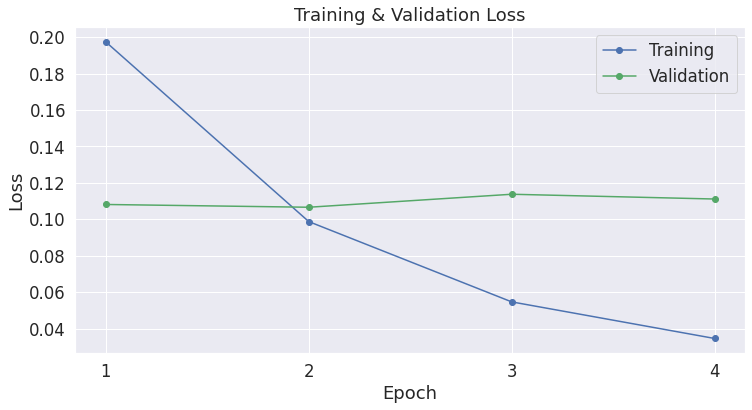

In [31]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [32]:
total_test_loss = []
total_test_accuracy = []



for batch in validation_dataloader:

        
  # Unpack this training batch from our dataloader. 
  #
  # As we unpack the batch, we'll also copy each tensor to the GPU using 
  # the `to` method.
  #
  # `batch` contains three pytorch tensors:
  #   [0]: input ids 
  #   [1]: attention masks
  #   [2]: labels 
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)
        
  # Tell pytorch not to bother with constructing the compute graph during
  # the forward pass, since this is only needed for backprop (training).
  #with torch.no_grad():        

  # Forward pass, calculate logit predictions.
  # token_type_ids is the same as the "segment ids", which 
  # differentiates sentence 1 and 2 in 2-sentence tasks.
  result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)
        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
  loss = result.loss
  logits = result.logits
        
            
        # Accumulate the validation loss.
  total_test_loss = loss.item()

        # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
  total_test_accuracy = flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
print("The total test accuracy is: ")
print(total_test_accuracy)
print("Testing complete!")

The total test accuracy is: 
1.0
Testing complete!


##Performance On Test Set

### Data Preparation


In [34]:

combinedDF['Label'] = combinedDF['Label'].astype(int, errors = 'raise')
sentences3 = combinedDF.Sentence.values
labels3 = combinedDF.Label.values

In [35]:
max_len3 = 0

# For every sentence...
for sent in sentences3:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids3 = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len3 = max(max_len3, len(input_ids3))

print('Max sentence length: ', max_len3)

Token indices sequence length is longer than the specified maximum sequence length for this model (1321 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  2141


In [36]:
input_ids3 = []
attention_masks3 = []

# For every sentence...
for sent in sentences3:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict3 = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids3.append(encoded_dict3['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks3.append(encoded_dict3['attention_mask'])

# Convert the lists into tensors.
input_ids3 = torch.cat(input_ids3, dim=0)
attention_masks3 = torch.cat(attention_masks3, dim=0)
labels3 = torch.tensor(labels3)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences3[0])
print('Token IDs:', input_ids3[0])


print(len(sentences3))


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  
Token IDs: tensor([    1,   250,   182,     6,   182,     6,   182,  2635,    12, 19838,
            6,  4374,  1672,  1569,    59,    10, 21460,     6, 29392,   664,
          313,     4,  1437,  1437,     2,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
2748


In [37]:
test_dataset = TensorDataset(input_ids3, attention_masks3, labels3)

print(type(input_ids3))        
print(type(attention_masks3))
print(type(labels3))



test_dataloader = DataLoader(        
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = 32 
        )


print(len(test_dataset))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
2748


In [38]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    2726 MB |    4255 MB |    3220 GB |    3217 GB |\n|       from large pool |    2715 MB |    4253 MB |    3190 GB |    3187 GB |\n|       from small pool |      11 MB |      40 MB |      29 GB |      29 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |    2726 MB |    4255 MB |    3220 GB |    3217 GB |\n|       from large pool |    2715 MB |    4253 MB |

In [39]:
total_test_loss = []
total_test_accuracy = []



for batch in test_dataloader:

        
  # Unpack this training batch from our dataloader. 
  #
  # As we unpack the batch, we'll also copy each tensor to the GPU using 
  # the `to` method.
  #
  # `batch` contains three pytorch tensors:
  #   [0]: input ids 
  #   [1]: attention masks
  #   [2]: labels 
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)
        
  # Tell pytorch not to bother with constructing the compute graph during
  # the forward pass, since this is only needed for backprop (training).
  #with torch.no_grad():        

  # Forward pass, calculate logit predictions.
  # token_type_ids is the same as the "segment ids", which 
  # differentiates sentence 1 and 2 in 2-sentence tasks.
  result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)
        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
  loss = result.loss
  logits = result.logits
        
            
        # Accumulate the validation loss.
  total_test_loss = loss.item()

        # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
  total_test_accuracy = flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
print("The total test accuracy is: ")
print(total_test_accuracy)
print("Testing complete!")

The total test accuracy is: 
0.9642857142857143
Testing complete!
